In [234]:
import numpy as np
import copy
import pandas as pd

`target_vars` - coefficients of target function

`target_q` - free number of targer function

`target_direction` - min or max of targer function

`const_a` - matrix of coefficients in constrains

`const_b` - matrix of right part of constraints

In [226]:
class SimplexTable:
    def __init__(self, target_vars, target_q, target_direction, const_a, const_b):
        # top
        self.inds_free_vars = np.arange(target_vars.shape[0])
        # left
        self.inds_basis_vars = np.arange(self.inds_free_vars[-1] + 1, self.inds_free_vars[-1] + 1 + const_b.shape[0])

        if(target_direction == 'max'):
            target_vars *= -1
            target_q *= -1

        # bottom
        self.c = target_vars
        # right
        self.b = const_b
        # center
        self.a = const_a

        # -Q
        self.cur_F = -target_q
        
    def recalculate_table(self, selected_row, selected_column):
        # Копии элементов
        prev_a = copy.deepcopy(self.a)
        prev_c = copy.deepcopy(self.c)
        prev_b = copy.deepcopy(self.b)
        
        # Разрешающий элемент
        selected_a = self.a[selected_row, selected_column]
        # Меняем разрешающую строку
        self.a[selected_row] /= selected_a
        self.b[selected_row] /= selected_a
        # Меняем разрешающий столбец
        self.c[selected_column] /= -selected_a
        self.a[:, selected_column] = [prev_a[i, selected_column]/-selected_a  if i != selected_row else prev_a[i, selected_column] for i in range(prev_a.shape[0])]
            
        # Меняем остальные элементы
        for i in range(prev_a.shape[0]):
            if(i == selected_row):
                continue
            # Меняем b
            self.b[i] -= prev_b[selected_row] * prev_a[i, selected_column] / selected_a
            for j in range(prev_a.shape[1]):
                if(j == selected_column):
                    continue
                self.a[i, j] -= prev_a[selected_row, j] * prev_a[i, selected_column] / selected_a
                
        # Меняем коэффициенты целевой функции (с)
        for j in range(prev_a.shape[1]):
                if(j == selected_column):
                    continue
                self.c[j] -= prev_a[selected_row, j] * prev_c[selected_column] / selected_a
                
        # Меняем cur_F
        self.cur_F -= prev_b[selected_row] * prev_c[selected_column] / selected_a
        
        # Переносим разрещающий столбец в базис, разрещаю строку в свободные перменные
        self.inds_basis_vars[selected_row], self.inds_free_vars[selected_column] = self.inds_free_vars[selected_column], self.inds_basis_vars[selected_row]
        
    def answer(self):
        xs = np.zeros((1, self.inds_free_vars.shape[0] + self.inds_basis_vars.shape[0]))[0]
        
        for ind_bas, cur_b in zip(self.inds_basis_vars, self.b):
            xs[ind_bas] = cur_b
        
        return xs, -self.cur_F

In [228]:
def check_optim(c):
    return (c >= 0).all()

def select_column(c):
    return np.argmin(c)

def select_row(selected_column, b, a):
    arr = [b[i] / a[i, selected_column] if a[i, selected_column] != 0 else np.inf for i in range(b.shape[0])]
    return np.argmin(arr)

### Simplex table

In [260]:
def st_df(st):    
    simp_table = pd.DataFrame(index=st.inds_basis_vars, columns=st.inds_free_vars).fillna(0)
    columns = simp_table.columns.values

    for i in range(columns.shape[0]):
        simp_table[columns[i]] = st.a[:, i]

    simp_table.loc['c/W*'] = st.c
    simp_table['b/W*'] = np.append(st.b, st.cur_F)
    return simp_table

In [270]:
def simplex_opt(target_vars, target_q, target_dir, const_a, const_b): 
    iter_limit = 10000
    cur_iter = 0

    st = SimplexTable(target_vars, target_q, target_dir, const_a, const_b)

    while cur_iter < iter_limit and check_optim(st.c)==False:
        selected_column = select_column(st.c) # разрешающий столбец
        selected_row = select_row(selected_column, st.b, st.a) # разрешающая строка

        st.recalculate_table(selected_row, selected_column)
        cur_iter += 1

    answer = st.answer()
    print(st_df(st))
    print(f'Number of iterations: {cur_iter}')
    return answer

### Miro example

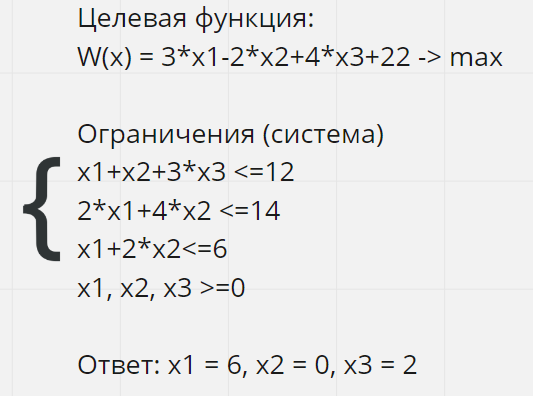

In [271]:
target_vars = np.array([3, -2, 4], dtype=np.float32)
target_q = 22
target_dir = 'max'
const_a = np.array([[1, 1, 3],
                    [2, 4, 0],
                    [1, 2, 0]], dtype=np.float32)
const_b = np.array([12, 14, 6], dtype=np.float32)

In [272]:
simplex_opt(target_vars, target_q, target_dir, const_a, const_b)

             5         1         3  b/W*
2    -0.333333 -0.333333  3.000000   2.0
4    -2.000000  0.000000  0.000000   2.0
0     1.000000  2.000000 -0.000000   6.0
c/W*  1.666667  6.666667  1.333333  48.0
Number of iterations: 2


(array([6., 0., 2., 0., 2., 0.]), -48.0)

### Own example

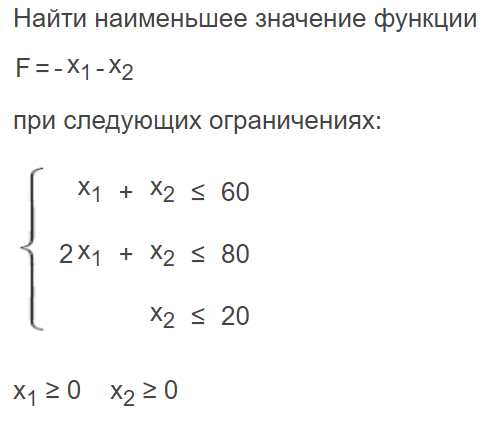

In [274]:
target_vars = np.array([-1, -1], dtype=np.float32)
target_q = 0
target_dir = 'min'
const_a = np.array([[1, 1],
                    [2, 1],
                    [0, 1]], dtype=np.float32)
const_b = np.array([60, 80, 20], dtype=np.float32)

simplex_opt(target_vars, target_q, target_dir, const_a, const_b)

        3    4  b/W*
2    -0.5 -0.5  10.0
0     2.0 -0.5  30.0
1    -0.0  1.0  20.0
c/W*  0.5  0.5  50.0
Number of iterations: 2


(array([30., 20., 10.,  0.,  0.]), -50.0)